In [27]:
import numpy as np
import matplotlib.pyplot as plt 
import os
import math
import shutil
import glob

In [16]:
ROOT_DIR="./data"
no_of_images={}
for dir in os.listdir(ROOT_DIR):
    no_of_images[dir]=len(os.listdir(os.path.join(ROOT_DIR,dir)))

# SPLIT RATIOS

#### 70% TRAIN
#### 15% TEST
#### 15% VALIDATION

In [17]:
def MakeDataFolder(pth,sliptRatio):
    if not os.path.exists("./"+pth):
        os.mkdir("./"+pth)
        
        for dir in os.listdir(ROOT_DIR):
            os.makedirs("./"+pth+"/"+dir)
            for img in np.random.choice(a=os.listdir(os.path.join(ROOT_DIR,dir)),size=(math.floor(sliptRatio*no_of_images[dir])-5),replace=False):
                O=os.path.join(ROOT_DIR,dir,img)
                D=os.path.join("./"+pth,dir)
                shutil.copy(O,D)
                os.remove(O)
    else:
        print(f"{pth}Folder exist")

In [1]:
from keras.layers import Conv2D,MaxPool2D,Dropout,Flatten,Dense,BatchNormalization,GlobalAvgPool2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import keras

In [2]:
model=Sequential()
model.add(Conv2D(filters=16,kernel_size=(3,3),activation='relu',input_shape=(224,224,3)))

model.add(Conv2D(filters=36,kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Dropout(rate=0.25))

model.add(Flatten())
model.add(Dense(units=64,activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(units=1,activation='sigmoid'))

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 36)      5220      
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 36)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 64)      20800     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 52, 52, 128)      

In [3]:
model.compile(optimizer='adam',loss=keras.losses.binary_crossentropy,metrics=['accuracy'])

In [4]:
def preprocessingImages(path):
  """
    input:Path
    output: Pre processes images
  """
  image_data=ImageDataGenerator(zoom_range=0.2,shear_range=0.2,rescale=1/255,horizontal_flip=True)
  image=image_data.flow_from_directory(directory=path,target_size=(224,224),batch_size=32,class_mode='binary')
  return image

In [5]:
pth="./train"
train_data=preprocessingImages(pth)

Found 1012 images belonging to 2 classes.


In [6]:
def preprocessingImages2(path):
  """
    input:Path
    output: Pre processes images
  """
  image_data=ImageDataGenerator(rescale=1/255)
  image=image_data.flow_from_directory(directory=path,target_size=(224,224),batch_size=32,class_mode='binary')
  return image

In [7]:
pth="./test"
test_data=preprocessingImages2(pth)

Found 208 images belonging to 2 classes.


In [8]:
train_data

In [9]:
pth="./val"
val_data=preprocessingImages2(pth)

Found 208 images belonging to 2 classes.


In [12]:
from keras.callbacks import ModelCheckpoint,EarlyStopping

es=EarlyStopping(monitor="val_accuracy",min_delta=0.01,patience=5,verbose=1,mode='auto')

mc=ModelCheckpoint(monitor="val_accuracy",filepath="./bestmodel.h5",verbose=1,save_best_only=True,mode='auto')
cd=[es,mc]

In [13]:
hs=model.fit(train_data,steps_per_epoch=8,epochs=30,verbose=1,validation_data=val_data,validation_steps=16,callbacks=cd)

Epoch 1/30
8/8 [==============================] - ETA: 0s - loss: 0.3537 - accuracy: 0.8443WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 16 batches). You may need to use the repeat() function when building your dataset.

Epoch 1: val_accuracy improved from -inf to 0.79327, saving model to .\bestmodel.h5
8/8 [==============================] - 10s 1s/step - loss: 0.3537 - accuracy: 0.8443 - val_loss: 0.4061 - val_accuracy: 0.7933
Epoch 2/30
8/8 [==============================] - 9s 1s/step - loss: 0.3510 - accuracy: 0.8484
Epoch 3/30
8/8 [==============================] - 9s 1s/step - loss: 0.3727 - accuracy: 0.8125
Epoch 4/30
8/8 [==============================] - 11s 1s/step - loss: 0.3061 - accuracy: 0.8516
Epoch 5/30
8/8 [==============================] - 10s 1s/step - loss: 0.3920 - accuracy: 0.7891
Epoch 6/30
8/8 [==============================] -

In [16]:
from keras.models import load_model

model=load_model('./bestmodel.h5')

In [18]:
acc=model.evaluate(test_data)[1]

7/7 [==============================] - 1s 165ms/step - loss: 0.3615 - accuracy: 0.8221


In [19]:
print(acc)

0.8221153616905212


In [20]:
from keras.preprocessing.image import load_img,img_to_array

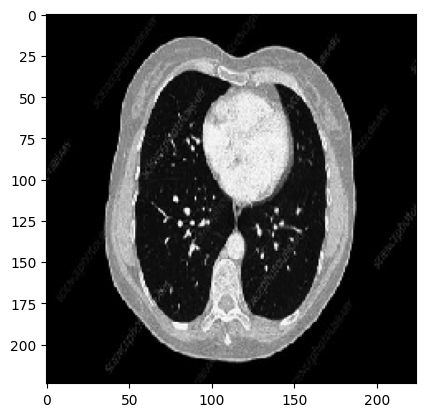

1/1 [==============================] - 0s 25ms/step
the ct scan shows a tumor in lungs


In [43]:
path="data/nm.jpg"

img=load_img(path,target_size=(224,224))
input_arr=img_to_array(img)/255

plt.imshow(input_arr)
plt.show()

input_arr=np.expand_dims(input_arr,axis=0)

pred = (model.predict(input_arr) ).astype("int32")[0][0]

if pred==0:
    print("the ct scan shows a tumor in lungs")
else:
    print("the ct scan shows no tumor")
